# XGBoost 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
import os
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

In [3]:
input_file = 'data/all_gene_annotations.added_incompleteness_and_contamination.tsv'
y = 'data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv'

#parametres
target_column = 'oxytolerance'
threads = 64

## Data

In [4]:
# Read GTDB
gtdb = pl.concat([
    pl.read_csv('data/bac120_metadata_r202.tsv', separator="\t"),
    pl.read_csv('data/ar122_metadata_r202.tsv', separator="\t")
])
gtdb = gtdb.filter(pl.col("gtdb_representative") == "t")
print("Read in {} GTDB reps".format(len(gtdb)))

gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(0).alias("domain"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(1).alias("phylum"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(2).alias("class"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(3).alias("order"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(4).alias("family"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(5).alias("genus"))

Read in 47894 GTDB reps


In [5]:
# Read full data (for EDA use train+test)
d = pl.read_csv(input_file,separator="\t")#accession fpr fnr {COGs}
print("Read full data: %s", d.shape)

# Add metadata (join based on accession)
d2 = d.join(gtdb.select(['accession','domain', 'phylum','class','order','family','genus']), on="accession", how="left")#accession fpr fnr {COGs} phylum class order family
#d2 = d.join(gtdb.select(['accession', 'phylum','class','order','family','genus']), on="accession", how="left")#accession fpr fnr {COGs} phylum class order family
print("Total in d2 full data: %s", d2.shape)

Read full data: %s (147744, 2680)
Total in d2 full data: %s (147744, 2686)


In [6]:
# Read y
y0 = pl.read_csv(y, separator="\t")
y1 = y0.unique() # There are some duplicates in the cyanos, so dedup
print("Read y: %s", y1.shape)
print("Counts of each class amongst unique accessions: %s", y1.group_by(target_column).agg(pl.len()))#FIXED

Read y: %s (3161, 2)
Counts of each class amongst unique accessions: %s shape: (2, 2)
┌──────────────┬──────┐
│ oxytolerance ┆ len  │
│ ---          ┆ ---  │
│ str          ┆ u32  │
╞══════════════╪══════╡
│ aerobe       ┆ 2106 │
│ anaerobe     ┆ 1055 │
└──────────────┴──────┘


In [7]:
d3 = d2.join(y1, on="accession", how="inner") # Inner join because test accessions are in y1 but not in d2
print("Counts of each class in training/test data: %s", d3.group_by(target_column).agg(pl.len()))

Counts of each class in training/test data: %s shape: (2, 2)
┌──────────────┬───────┐
│ oxytolerance ┆ len   │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ aerobe       ┆ 75816 │
│ anaerobe     ┆ 37980 │
└──────────────┴───────┘


In [8]:
d3_bf = d3

without noise (w/o FP & FN)

In [9]:
#w/o FP FN
print(f'Before filtering {len(d3)}')
d3 = d3.filter(pl.col("false_negative_rate") == 0)
d3 = d3.filter(pl.col("false_positive_rate") == 0)
print(f'After filtering {len(d3)}')

d3.head()

Before filtering 113796
After filtering 3161


accession,false_negative_rate,false_positive_rate,COG0001,COG0002,COG0003,COG0004,COG0005,COG0007,COG0008,COG0010,COG0012,COG0013,COG0015,COG0016,COG0017,COG0018,COG0019,COG0022,COG0023,COG0025,COG0026,COG0027,COG0028,COG0029,COG0030,COG0033,COG0035,COG0036,COG0038,COG0039,COG0041,COG0042,COG0043,COG0044,COG0045,COG0046,…,COG5525,COG5531,COG5542,COG5553,COG5554,COG5555,COG5557,COG5565,COG5569,COG5570,COG5571,COG5573,COG5581,COG5590,COG5592,COG5597,COG5598,COG5605,COG5606,COG5610,COG5611,COG5615,COG5621,COG5625,COG5632,COG5640,COG5643,COG5650,COG5652,COG5663,domain,phylum,class,order,family,genus,oxytolerance
str,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str
"""GB_GCA_000010565.1""",0.0,0.0,1,1,0,1,2,1,1,1,1,2,1,1,1,1,1,0,0,0,0,0,2,1,1,0,0,1,0,1,1,1,1,1,1,0,…,0,0,1,0,0,0,1,0,0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,"""d__Bacteria""","""p__Firmicutes_B""","""c__Desulfotomaculia""","""o__Desulfotomaculales""","""f__Pelotomaculaceae""","""g__Pelotomaculum""","""anaerobe"""
"""GB_GCA_000018565.1""",0.0,0.0,1,1,1,3,3,0,1,1,1,2,1,1,1,2,2,0,0,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,…,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,"""d__Bacteria""","""p__Chloroflexota""","""c__Chloroflexia""","""o__Chloroflexales""","""f__Herpetosiphonaceae""","""g__Herpetosiphon""","""aerobe"""
"""GB_GCA_000145985.1""",0.0,0.0,1,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,1,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""d__Archaea""","""p__Thermoproteota""","""c__Thermoproteia""","""o__Sulfolobales""","""f__Ignisphaeraceae""","""g__Ignisphaera""","""anaerobe"""
"""GB_GCA_000210715.1""",0.0,0.0,0,0,0,0,0,1,1,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,2,1,0,1,0,0,1,0,1,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""d__Bacteria""","""p__Synergistota""","""c__Synergistia""","""o__Synergistales""","""f__Aminobacteriaceae""","""g__Fretibacterium""","""anaerobe"""
"""GB_GCA_000214705.1""",0.0,0.0,1,1,0,1,2,1,1,2,1,1,1,1,0,1,1,0,0,0,0,0,2,1,1,0,0,1,0,1,1,1,1,1,2,0,…,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"""d__Bacteria""","""p__Firmicutes_B""","""c__Desulfotomaculia""","""o__Desulfotomaculales""","""f__Desulfovirgulaceae""","""g__Desulfofundulus""","""anaerobe"""


In [10]:
y = y1

classes_map = {
    'anaerobe': 0,
    'aerobe': 1,
}      

y = d3.with_columns(
    pl.col(target_column)
    .replace_strict(classes_map, default='unknown')
    .alias(target_column)
)

y = y.with_columns(
    pl.col(target_column).cast(pl.Int32)  # Change to Int32
)
            
print("Counts of y: %s", y.group_by(target_column).agg(pl.len()))

y = y.to_pandas()
y = y.iloc[:, -1]

Counts of y: %s shape: (2, 2)
┌──────────────┬──────┐
│ oxytolerance ┆ len  │
│ ---          ┆ ---  │
│ i32          ┆ u32  │
╞══════════════╪══════╡
│ 0            ┆ 1055 │
│ 1            ┆ 2106 │
└──────────────┴──────┘


In [11]:
#X = d3.select(pl.exclude(['accession',target_column,'phylum','class','order','family','genus','false_negative_rate','false_positive_rate'])).to_pandas()
X = d3.select(pl.exclude(['accession',target_column,'domain','phylum','class','order','family','genus','false_negative_rate','false_positive_rate'])).to_pandas()

# Blacklist these as they aren't in the current ancestral file, not sure why
X = X.drop(['COG0411', 'COG0459', 'COG0564', 'COG1344', 'COG4177'], axis=1)

X

,COG0001,COG0002,COG0003,COG0004,COG0005,COG0007,COG0008,COG0010,COG0012,COG0013,...,COG5611,COG5615,COG5621,COG5625,COG5632,COG5640,COG5643,COG5650,COG5652,COG5663
0,1,1,0,1,2,1,1,1,1,2,...,0,0,0,0,2,0,0,0,0,1
1,1,1,1,3,3,0,1,1,1,2,...,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,2,1,1,2,1,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156,1,1,0,2,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3157,2,1,0,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3158,1,2,0,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,0
3159,1,2,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0


## Model

In [12]:
#model
pipe = make_pipeline(
    MaxAbsScaler(),
    XGBClassifier(n_jobs=threads, use_label_encoder=False)
)

## Test/Train split

### By domain (bact -> train arch -> test)

In [13]:
groups = d3['domain']
groups

data = pd.DataFrame(X)
data['target'] = y
data['group'] = groups
data

unique_group = data['group'].unique()
unique_group

#train_groups, test_groups = train_test_split(unique_group, test_size=0.2, random_state=42)#Not for the domain
train_groups = ['d__Bacteria']
test_groups = ['d__Archaea']

train_mask = data['group'].isin(train_groups)
test_mask = data['group'].isin(test_groups)
train_mask

X_train = data[train_mask].drop(columns=['target', 'group']).values
y_train = data[train_mask]['target'].values
X_test = data[test_mask].drop(columns=['target', 'group']).values
y_test = data[test_mask]['target'].values

print(f'Train/test split is {(len(y_train)/(len(y_train) + len(y_test)) * 100):.0f}%/{(len(y_test)/(len(y_train) + len(y_test)) * 100):.0f}%')
print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

Train/test split is 94%/6%
Train: 2976	Test: 185


In [14]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, pipe.predict(X_train))
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)
mean_cv_accuracy = np.mean(cv_scores)

In [15]:
print(f'CV_Accuracy = {mean_cv_accuracy:.2f}\nAccuracy = {accuracy_score(y_test, y_pred):.2f}\nBalanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nF1 = {f1_score(y_test, y_pred):.2f}')

CV_Accuracy = 0.98
Accuracy = 0.95
Balanced Accuracy = 0.96
Precision = 0.89
Recall = 0.96
F1 = 0.92


### By phylum

In [16]:
groups = d3['phylum']
groups

data = pd.DataFrame(X)
data['target'] = y
data['group'] = groups
data

unique_group = data['group'].unique()
unique_group

train_groups, test_groups = train_test_split(unique_group, test_size=0.2, random_state=42)#Not for the domain
train_groups
test_groups

print(f'Train groups: {len(train_groups)}\tTest groups: {len(test_groups)}')

train_mask = data['group'].isin(train_groups)
test_mask = data['group'].isin(test_groups)
train_mask
test_mask

X_train = data[train_mask].drop(columns=['target', 'group']).values
y_train = data[train_mask]['target'].values
X_test = data[test_mask].drop(columns=['target', 'group']).values
y_test = data[test_mask]['target'].values

print(f'Train/test split is {(len(y_train)/(len(y_train) + len(y_test)) * 100):.0f}%/{(len(y_test)/(len(y_train) + len(y_test)) * 100):.0f}%')
print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

Train groups: 36	Test groups: 9
Train/test split is 87%/13%
Train: 2752	Test: 409


In [17]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, pipe.predict(X_train))
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)
mean_cv_accuracy = np.mean(cv_scores)

In [18]:
print(f'CV_Accuracy = {mean_cv_accuracy:.2f}\nAccuracy = {accuracy_score(y_test, y_pred):.2f}\nBalanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nF1 = {f1_score(y_test, y_pred):.2f}')

CV_Accuracy = 0.97
Accuracy = 0.99
Balanced Accuracy = 1.00
Precision = 0.95
Recall = 1.00
F1 = 0.97


### By class

In [19]:
groups = d3['class']
groups

data = pd.DataFrame(X)
data['target'] = y
data['group'] = groups
data

unique_group = data['group'].unique()
unique_group

train_groups, test_groups = train_test_split(unique_group, test_size=0.2, random_state=42)
train_groups
test_groups

print(f'Train groups: {len(train_groups)}\tTest groups: {len(test_groups)}')

train_mask = data['group'].isin(train_groups)
test_mask = data['group'].isin(test_groups)
train_mask
test_mask

X_train = data[train_mask].drop(columns=['target', 'group']).values
y_train = data[train_mask]['target'].values
X_test = data[test_mask].drop(columns=['target', 'group']).values
y_test = data[test_mask]['target'].values

print(f'Train/test split is {(len(y_train)/(len(y_train) + len(y_test)) * 100):.0f}%/{(len(y_test)/(len(y_train) + len(y_test)) * 100):.0f}%')
print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

Train groups: 81	Test groups: 21
Train/test split is 80%/20%
Train: 2526	Test: 635


In [20]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, pipe.predict(X_train))
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)
mean_cv_accuracy = np.mean(cv_scores)

In [21]:
print(f'CV_Accuracy = {mean_cv_accuracy:.2f}\nAccuracy = {accuracy_score(y_test, y_pred):.2f}\nBalanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nF1 = {f1_score(y_test, y_pred):.2f}')

CV_Accuracy = 0.97
Accuracy = 0.94
Balanced Accuracy = 0.92
Precision = 0.94
Recall = 0.97
F1 = 0.96


### By order

In [22]:
groups = d3['order']
groups

data = pd.DataFrame(X)
data['target'] = y
data['group'] = groups
data

unique_group = data['group'].unique()
unique_group

train_groups, test_groups = train_test_split(unique_group, test_size=0.2, random_state=42)
train_groups
test_groups

print(f'Train groups: {len(train_groups)}\tTest groups: {len(test_groups)}')

train_mask = data['group'].isin(train_groups)
test_mask = data['group'].isin(test_groups)
train_mask
test_mask

X_train = data[train_mask].drop(columns=['target', 'group']).values
y_train = data[train_mask]['target'].values
X_test = data[test_mask].drop(columns=['target', 'group']).values
y_test = data[test_mask]['target'].values

print(f'Train/test split is {(len(y_train)/(len(y_train) + len(y_test)) * 100):.0f}%/{(len(y_test)/(len(y_train) + len(y_test)) * 100):.0f}%')
print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

Train groups: 199	Test groups: 50
Train/test split is 81%/19%
Train: 2548	Test: 613


In [23]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, pipe.predict(X_train))
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)
mean_cv_accuracy = np.mean(cv_scores)

In [24]:
print(f'CV_Accuracy = {mean_cv_accuracy:.2f}\nAccuracy = {accuracy_score(y_test, y_pred):.2f}\nBalanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nF1 = {f1_score(y_test, y_pred):.2f}')

CV_Accuracy = 0.97
Accuracy = 0.98
Balanced Accuracy = 0.98
Precision = 0.98
Recall = 0.98
F1 = 0.98


### By family

In [25]:
groups = d3['family']
groups

data = pd.DataFrame(X)
data['target'] = y
data['group'] = groups
data

unique_group = data['group'].unique()
unique_group

train_groups, test_groups = train_test_split(unique_group, test_size=0.2, random_state=42)
train_groups
test_groups

print(f'Train groups: {len(train_groups)}\tTest groups: {len(test_groups)}')

train_mask = data['group'].isin(train_groups)
test_mask = data['group'].isin(test_groups)
train_mask
test_mask

X_train = data[train_mask].drop(columns=['target', 'group']).values
y_train = data[train_mask]['target'].values
X_test = data[test_mask].drop(columns=['target', 'group']).values
y_test = data[test_mask]['target'].values

print(f'Train/test split is {(len(y_train)/(len(y_train) + len(y_test)) * 100):.0f}%/{(len(y_test)/(len(y_train) + len(y_test)) * 100):.0f}%')
print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

Train groups: 443	Test groups: 111
Train/test split is 74%/26%
Train: 2340	Test: 821


In [26]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, pipe.predict(X_train))
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)
mean_cv_accuracy = np.mean(cv_scores)

In [27]:
print(f'CV_Accuracy = {mean_cv_accuracy:.2f}\nAccuracy = {accuracy_score(y_test, y_pred):.2f}\nBalanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nF1 = {f1_score(y_test, y_pred):.2f}')

CV_Accuracy = 0.97
Accuracy = 0.96
Balanced Accuracy = 0.94
Precision = 0.96
Recall = 0.99
F1 = 0.98


### By genus

In [28]:
groups = d3['genus']
groups

data = pd.DataFrame(X)
data['target'] = y
data['group'] = groups
data

unique_group = data['group'].unique()
unique_group

train_groups, test_groups = train_test_split(unique_group, test_size=0.2, random_state=42)
train_groups
test_groups

print(f'Train groups: {len(train_groups)}\tTest groups: {len(test_groups)}')

train_mask = data['group'].isin(train_groups)
test_mask = data['group'].isin(test_groups)
train_mask
test_mask

X_train = data[train_mask].drop(columns=['target', 'group']).values
y_train = data[train_mask]['target'].values
X_test = data[test_mask].drop(columns=['target', 'group']).values
y_test = data[test_mask]['target'].values

print(f'Train/test split is {(len(y_train)/(len(y_train) + len(y_test)) * 100):.0f}%/{(len(y_test)/(len(y_train) + len(y_test)) * 100):.0f}%')
print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

Train groups: 1654	Test groups: 414
Train/test split is 81%/19%
Train: 2546	Test: 615


In [29]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, pipe.predict(X_train))
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)
mean_cv_accuracy = np.mean(cv_scores)

In [30]:
print(f'CV_Accuracy = {mean_cv_accuracy:.2f}\nAccuracy = {accuracy_score(y_test, y_pred):.2f}\nBalanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nF1 = {f1_score(y_test, y_pred):.2f}')

CV_Accuracy = 0.97
Accuracy = 0.98
Balanced Accuracy = 0.98
Precision = 0.98
Recall = 0.99
F1 = 0.99


In [31]:
d3

accession,false_negative_rate,false_positive_rate,COG0001,COG0002,COG0003,COG0004,COG0005,COG0007,COG0008,COG0010,COG0012,COG0013,COG0015,COG0016,COG0017,COG0018,COG0019,COG0022,COG0023,COG0025,COG0026,COG0027,COG0028,COG0029,COG0030,COG0033,COG0035,COG0036,COG0038,COG0039,COG0041,COG0042,COG0043,COG0044,COG0045,COG0046,…,COG5525,COG5531,COG5542,COG5553,COG5554,COG5555,COG5557,COG5565,COG5569,COG5570,COG5571,COG5573,COG5581,COG5590,COG5592,COG5597,COG5598,COG5605,COG5606,COG5610,COG5611,COG5615,COG5621,COG5625,COG5632,COG5640,COG5643,COG5650,COG5652,COG5663,domain,phylum,class,order,family,genus,oxytolerance
str,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str
"""GB_GCA_000010565.1""",0.0,0.0,1,1,0,1,2,1,1,1,1,2,1,1,1,1,1,0,0,0,0,0,2,1,1,0,0,1,0,1,1,1,1,1,1,0,…,0,0,1,0,0,0,1,0,0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,"""d__Bacteria""","""p__Firmicutes_B""","""c__Desulfotomaculia""","""o__Desulfotomaculales""","""f__Pelotomaculaceae""","""g__Pelotomaculum""","""anaerobe"""
"""GB_GCA_000018565.1""",0.0,0.0,1,1,1,3,3,0,1,1,1,2,1,1,1,2,2,0,0,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,…,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,"""d__Bacteria""","""p__Chloroflexota""","""c__Chloroflexia""","""o__Chloroflexales""","""f__Herpetosiphonaceae""","""g__Herpetosiphon""","""aerobe"""
"""GB_GCA_000145985.1""",0.0,0.0,1,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,1,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""d__Archaea""","""p__Thermoproteota""","""c__Thermoproteia""","""o__Sulfolobales""","""f__Ignisphaeraceae""","""g__Ignisphaera""","""anaerobe"""
"""GB_GCA_000210715.1""",0.0,0.0,0,0,0,0,0,1,1,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,2,1,0,1,0,0,1,0,1,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""d__Bacteria""","""p__Synergistota""","""c__Synergistia""","""o__Synergistales""","""f__Aminobacteriaceae""","""g__Fretibacterium""","""anaerobe"""
"""GB_GCA_000214705.1""",0.0,0.0,1,1,0,1,2,1,1,2,1,1,1,1,0,1,1,0,0,0,0,0,2,1,1,0,0,1,0,1,1,1,1,1,2,0,…,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"""d__Bacteria""","""p__Firmicutes_B""","""c__Desulfotomaculia""","""o__Desulfotomaculales""","""f__Desulfovirgulaceae""","""g__Desulfofundulus""","""anaerobe"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""RS_GCF_902813185.1""",0.0,0.0,1,1,0,2,0,0,0,0,1,1,1,1,0,1,1,0,0,0,1,1,5,1,1,0,0,1,0,0,1,1,1,1,1,0,…,2,0,0,0,0,0,2,0,5,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""d__Bacteria""","""p__Proteobacteria""","""c__Gammaproteobacteria""","""o__Burkholderiales""","""f__Rhodocyclaceae""","""g__Denitratisoma""","""aerobe"""
"""RS_GCF_902825325.1""",0.0,0.0,2,1,0,1,0,0,0,1,1,1,1,1,0,1,1,0,0,0,1,0,4,1,1,1,1,1,2,1,1,1,1,2,1,1,…,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""d__Bacteria""","""p__Proteobacteria""","""c__Alphaproteobacteria""","""o__Rhizobiales_A""","""f__Rhizobiaceae_A""","""g__Ochrobactrum""","""aerobe"""
"""RS_GCF_902859645.1""",0.0,0.0,1,2,0,1,0,0,0,1,1,1,1,1,0,1,2,1,1,1,1,1,7,0,1,0,1,1,5,0,1,1,1,2,1,0,…,1,1,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,"""d__Bacteria""","""p__Proteobacteria""","""c__Gammaproteobacteria""","""o__Burkholderiales""","""f__Burkholderiaceae""","""g__Achromobacter""","""aerobe"""


### Random

In [32]:
groups = d3['accession']
groups

data = pd.DataFrame(X)
data['target'] = y
data['group'] = groups
data

unique_group = data['group'].unique()
unique_group
len(unique_group)

train_groups, test_groups = train_test_split(unique_group, test_size=0.2, random_state=42)
train_groups
test_groups

print(f'Train groups: {len(train_groups)}\tTest groups: {len(test_groups)}')

train_mask = data['group'].isin(train_groups)
test_mask = data['group'].isin(test_groups)
train_mask
test_mask

X_train = data[train_mask].drop(columns=['target', 'group']).values
y_train = data[train_mask]['target'].values
X_test = data[test_mask].drop(columns=['target', 'group']).values
y_test = data[test_mask]['target'].values

print(f'Train/test split is {(len(y_train)/(len(y_train) + len(y_test)) * 100):.0f}%/{(len(y_test)/(len(y_train) + len(y_test)) * 100):.0f}%')
print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

Train groups: 2528	Test groups: 633
Train/test split is 80%/20%
Train: 2528	Test: 633


In [33]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, pipe.predict(X_train))
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)
mean_cv_accuracy = np.mean(cv_scores)

In [34]:
print(f'CV_Accuracy = {mean_cv_accuracy:.2f}\nAccuracy = {accuracy_score(y_test, y_pred):.2f}\nBalanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nF1 = {f1_score(y_test, y_pred):.2f}')

CV_Accuracy = 0.97
Accuracy = 0.98
Balanced Accuracy = 0.97
Precision = 0.98
Recall = 0.98
F1 = 0.98


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1408)

print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

Train: 2528	Test: 633


In [36]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_pred

array([0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,

In [37]:
print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nBalanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nF1 = {f1_score(y_test, y_pred):.2f}')

Accuracy = 0.99
Balanced Accuracy = 0.99
Precision = 0.99
Recall = 0.99
F1 = 0.99


In [38]:
pipe['xgbclassifier'].get_booster().feature_names = list(X.columns)
feature_important = pipe['xgbclassifier'].get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score")

,score
COG1328,15.0
COG1249,11.0
COG2352,10.0
COG1335,9.0
COG4231,9.0
COG1592,9.0
COG1002,9.0
COG1350,8.0
COG0109,8.0
COG2905,8.0


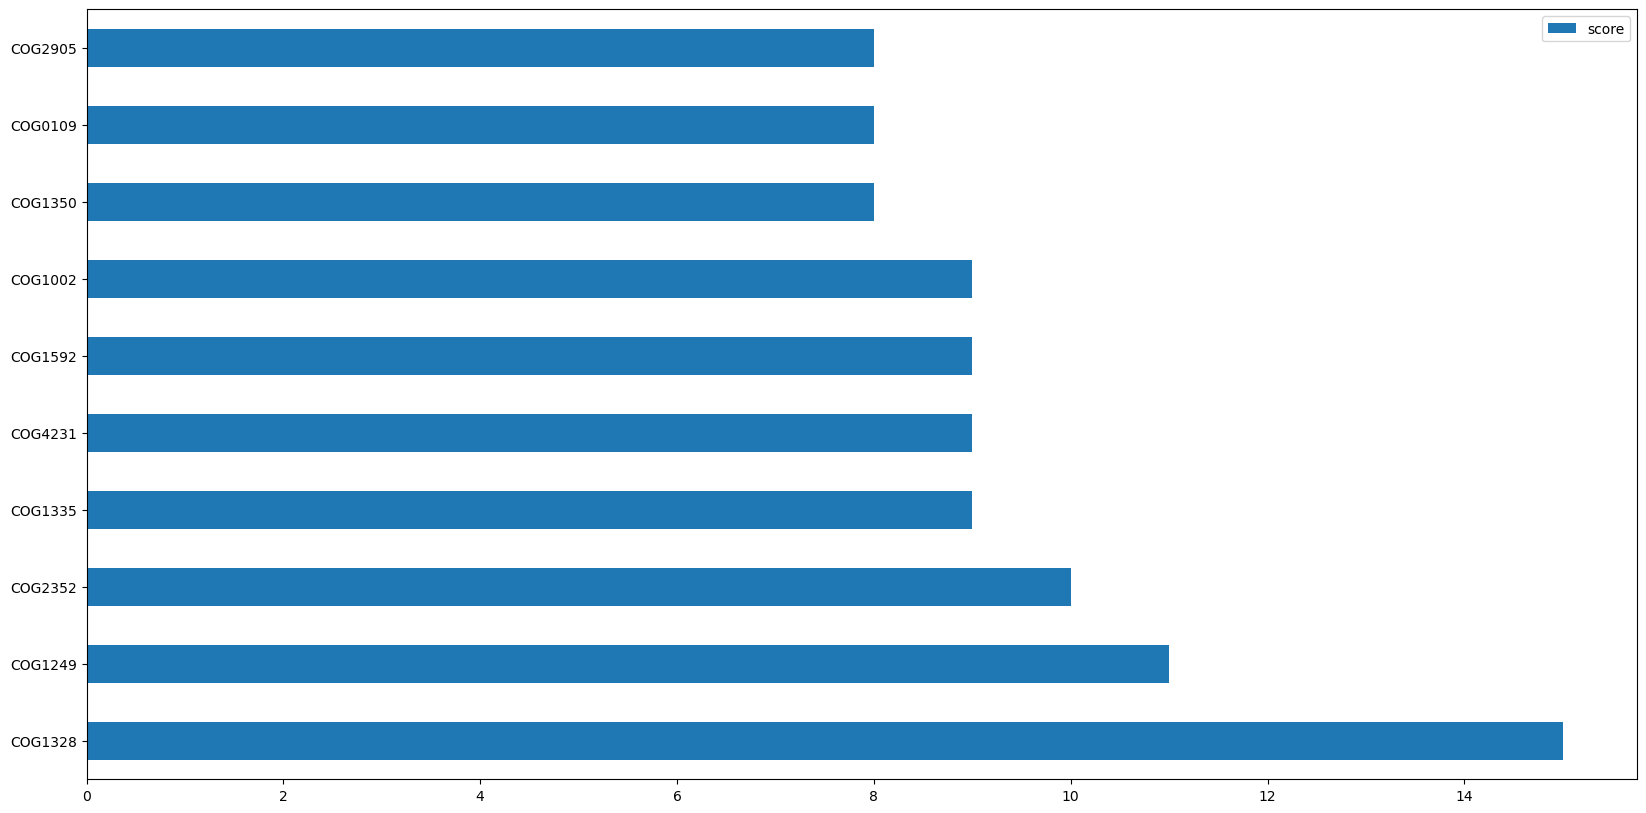

In [39]:
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10));

### Another scaler

In [43]:
pipe_sc = make_pipeline(
    StandardScaler(),
    #MaxAbsScaler(),
    #LogisticRegression(max_iter=1000,n_jobs=n_jobs)
    XGBClassifier(n_jobs=threads, use_label_encoder=False)
)

In [44]:
data = pd.DataFrame(X)
data['target'] = y
data['group'] = groups

unique_group = data['group'].unique()

train_groups, test_groups = train_test_split(unique_group, test_size=0.2, random_state=42)

train_mask = data['group'].isin(train_groups)
test_mask = data['group'].isin(test_groups)

X_train = data[train_mask].drop(columns=['target', 'group']).values
y_train = data[train_mask]['target'].values
X_test = data[test_mask].drop(columns=['target', 'group']).values
y_test = data[test_mask]['target'].values

In [45]:
print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

Train: 2528	Test: 633


In [46]:
pipe_sc.fit(X_train, y_train)
y_pred = pipe_sc.predict(X_test)
y_pred

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [47]:
print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nBalanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nF1 = {f1_score(y_test, y_pred):.2f}')

Accuracy = 0.98
Balanced Accuracy = 0.97
Precision = 0.98
Recall = 0.98
F1 = 0.98


In [48]:
pipe_sc['xgbclassifier']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=64,
              num_parallel_tree=None, random_state=None, ...)

In [49]:
pipe_sc['xgbclassifier'].get_booster().feature_names = list(X.columns)
feature_important = pipe_sc['xgbclassifier'].get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score")

,score
COG1328,14.0
COG0026,9.0
COG4231,9.0
COG0783,9.0
COG3604,8.0
COG0038,8.0
COG0370,8.0
COG0132,8.0
COG0109,8.0
COG2352,8.0


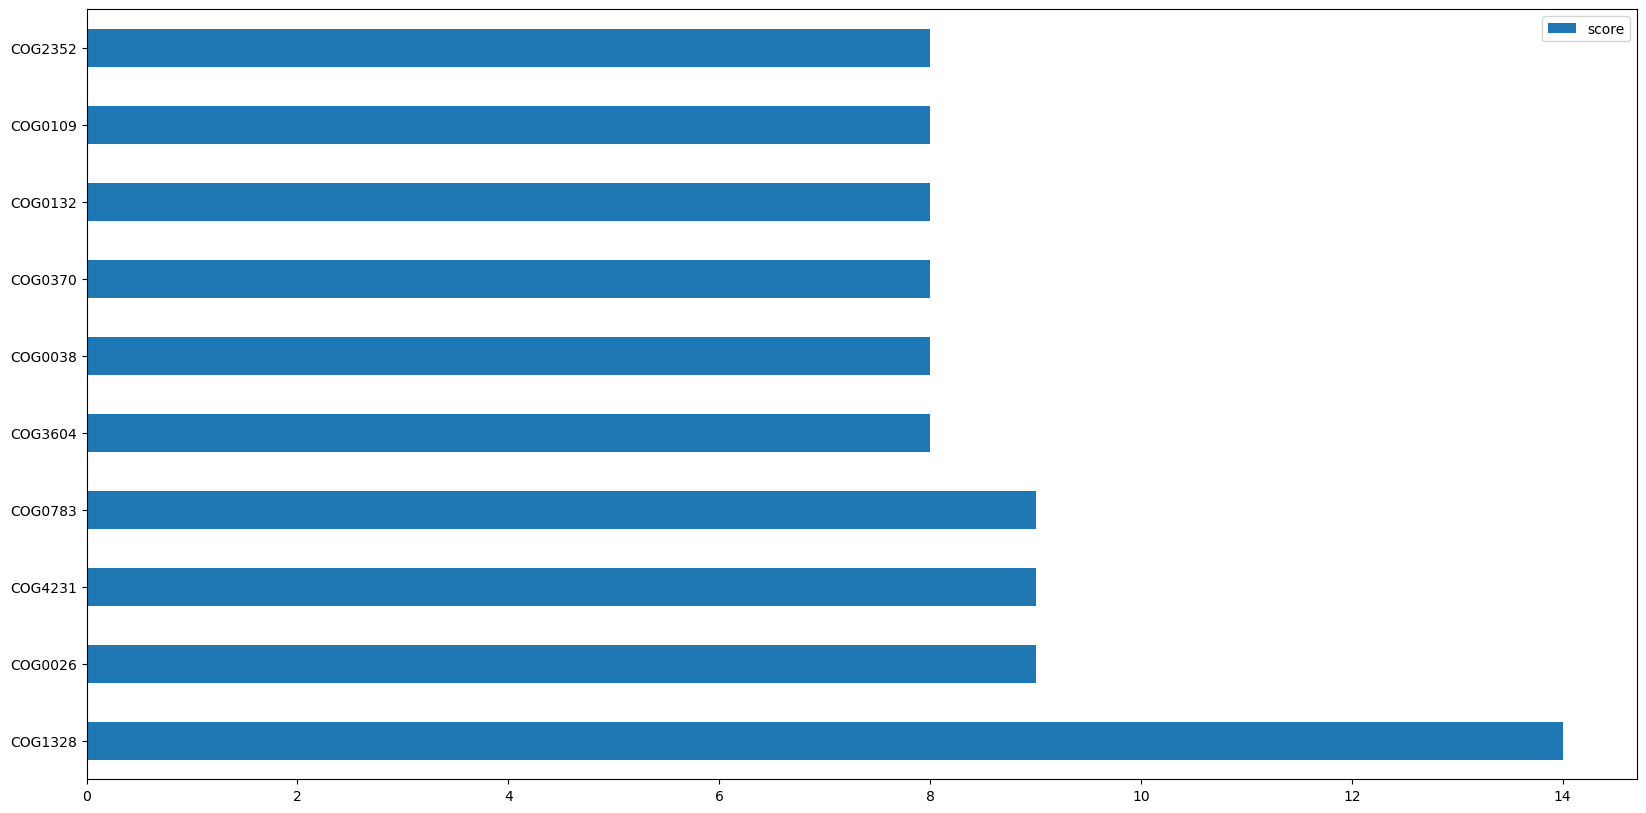

In [50]:
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10));

In [ ]:
# Use top-100 corr features

data = X.copy()
data['target'] = y

correlations = data.corr()['target'].drop('target')

top_100_correlations = correlations.abs().nlargest(100)
top_100_corr_features = list(top_100_correlations.index)

top_100_corr_features

In [ ]:
data = pd.DataFrame(X[top_100_corr_features])
data['target'] = y
data['group'] = groups#families

unique_group = data['group'].unique()

train_groups, test_groups = train_test_split(unique_group, test_size=0.2, random_state=42)

train_mask = data['group'].isin(train_groups)
test_mask = data['group'].isin(test_groups)

X_train = data[train_mask].drop(columns=['target', 'group']).values
y_train = data[train_mask]['target'].values
X_test = data[test_mask].drop(columns=['target', 'group']).values
y_test = data[test_mask]['target'].values

In [ ]:
X_train.shape #before: )(1942, 2672)

In [ ]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_pred

In [ ]:
print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nBalanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nF1 = {f1_score(y_test, y_pred):.2f}')

In [ ]:
pipe['xgbclassifier'].get_booster().feature_names = top_100_corr_features
feature_important = pipe['xgbclassifier'].get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score")

In [ ]:
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10));

In [ ]:
X

In [ ]:
features = list(X.columns)
stat_results = pd.DataFrame(columns=['COG', 'statistic', 'p-value', 'test_type'])
stat_results

for feature in tqdm(features):

    x_0 = X[y == 0][feature]
    x_1 = X[y == 1][feature]

    #test_type = 'exact'
    test_type = 'asymptotic'
    U1, p = mannwhitneyu(x_0, x_1, method=test_type)

    # if np.isnan(p):
    #     test_type = 'asymptotic'
    #     U1, p = mannwhitneyu(x_0, x_1, method=test_type)

    #row = {'COG': features, 'statistic': U1, 'p-value': p, 'test_type': test_type}
    stat_results.loc[len(stat_results)] = [feature, U1, p, test_type]
        
stat_results    

In [ ]:
stat_results[stat_results['p-value'] > 0.05]['COG']

In [ ]:
significant_cogs = list(stat_results[stat_results['p-value'] > 0.05]['COG'])
significant_cogs

In [ ]:
len(significant_cogs)

In [ ]:
X[significant_cogs]

**With taking into account families**

In [ ]:
data = pd.DataFrame(X[significant_cogs])
data['target'] = y
data['group'] = groups#families

unique_group = data['group'].unique()

train_groups, test_groups = train_test_split(unique_group, test_size=0.2, random_state=42)

train_mask = data['group'].isin(train_groups)
test_mask = data['group'].isin(test_groups)

X_train = data[train_mask].drop(columns=['target', 'group']).values
y_train = data[train_mask]['target'].values
X_test = data[test_mask].drop(columns=['target', 'group']).values
y_test = data[test_mask]['target'].values

In [ ]:
print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

In [ ]:
print(f'Train: {X_train.shape[1]}\tTest: {X_test.shape[1]}')

In [ ]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_pred

In [ ]:
print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nBalanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nF1 = {f1_score(y_test, y_pred):.2f}')

In [ ]:
pipe['xgbclassifier'].get_booster().feature_names = list(X[significant_cogs].columns)#["your", "feature", "name", "list"]
feature_important = pipe['xgbclassifier'].get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score")

In [ ]:
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10));

**to compare with random sample of 368 features (significant and non-significant)**

In [ ]:
features = list(X.columns)
random.seed(42)
sampled_features = [features[i] for i in sorted(random.sample(range(len(features)), 368))]
sampled_features

In [ ]:
print(len(set(sampled_features) - set(significant_cogs)))
set(sampled_features) - set(significant_cogs)

In [ ]:
X[sampled_features]

**With taking into account families**

In [ ]:
data = pd.DataFrame(X[sampled_features])
data['target'] = y
data['group'] = groups#families

unique_group = data['group'].unique()

train_groups, test_groups = train_test_split(unique_group, test_size=0.2, random_state=42)

train_mask = data['group'].isin(train_groups)
test_mask = data['group'].isin(test_groups)

X_train = data[train_mask].drop(columns=['target', 'group']).values
y_train = data[train_mask]['target'].values
X_test = data[test_mask].drop(columns=['target', 'group']).values
y_test = data[test_mask]['target'].values

In [ ]:
print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

In [ ]:
print(f'Train: {X_train.shape[1]}\tTest: {X_test.shape[1]}')

In [ ]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_pred

In [ ]:
print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nBalanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nF1 = {f1_score(y_test, y_pred):.2f}')

In [ ]:
pipe['xgbclassifier'].get_booster().feature_names = list(X[sampled_features].columns)#["your", "feature", "name", "list"]
feature_important = pipe['xgbclassifier'].get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score")

In [ ]:
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10));

In [ ]:
X_y = X
X_y['target'] = y

In [ ]:
#p>0.5
plt.figure(figsize=(10, 6))
sns.histplot(data=X_y, x='COG0010', hue='target', multiple="dodge")#, element="step");

In [ ]:
#p<0.5
plt.figure(figsize=(10, 6))
sns.histplot(data=X_y, x='COG0001', hue='target', multiple="dodge")#, element="step");

In [ ]:
#top-1 correlated with target
print(stat_results[stat_results['COG'] == 'COG0109']['p-value'])
plt.figure(figsize=(10, 6))
sns.histplot(data=X_y, x='COG0109', hue='target', multiple="dodge");#, element="step");

In [ ]:
x_0 = X[y == 0]['COG0109']
x_1 = X[y == 1]['COG0109']

#test_type = 'exact'
test_type = 'asymptotic'
U1, p = mannwhitneyu(x_0, x_1, method=test_type)
U1

In [ ]:
d3

In [ ]:
X = d3.select(pl.exclude(['accession',target_column,'phylum','class','order','family','genus','false_negative_rate','false_positive_rate'])).to_pandas()
# Map oxytolerance to 0, 1
classes_map = {
    'anaerobe': 0,
    'aerobe': 1,
}      

In [ ]:
X

In [ ]:
y = y1

y = d3.with_columns(
    pl.col(target_column)
    .replace_strict(classes_map, default='unknown')
    .alias(target_column)
)

y = y.with_columns(
    pl.col(target_column).cast(pl.Int32)  # Change to Int32
)
            
print("Counts of y: %s", y.group_by(target_column).agg(pl.len()))

In [ ]:
y

In [ ]:
y = y.to_pandas()
y = y.iloc[:, -1]

groups = d3['family'].to_list()

d_gtdb = d3.to_pandas()

# Blacklist these as they aren't in the current ancestral file, not sure why
X = X.drop(['COG0411', 'COG0459', 'COG0564', 'COG1344', 'COG4177'],axis=1)

**With taking into account families**

In [ ]:
data = pd.DataFrame(X)
data['target'] = y
data['group'] = groups#families

unique_group = data['group'].unique()

train_groups, test_groups = train_test_split(unique_group, test_size=0.2, random_state=42)

train_mask = data['group'].isin(train_groups)
test_mask = data['group'].isin(test_groups)

X_train = data[train_mask].drop(columns=['target', 'group']).values
y_train = data[train_mask]['target'].values
X_test = data[test_mask].drop(columns=['target', 'group']).values
y_test = data[test_mask]['target'].values

In [ ]:
print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

In [ ]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_pred

In [ ]:
print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nBalanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nF1 = {f1_score(y_test, y_pred):.2f}')

In [ ]:
pipe['xgbclassifier'].get_booster().feature_names = list(X.columns)#["your", "feature", "name", "list"]
feature_important = pipe['xgbclassifier'].get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score")

In [ ]:
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10));

In [ ]:
X

In [ ]:
X_for_shap = X_test
scaler = pipe['maxabsscaler']
X_for_shap_scaled = scaler.fit_transform(X_for_shap)

model = pipe['xgbclassifier']
pred = model.predict(X_for_shap_scaled, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(X_for_shap_scaled)

shap_values = explanation.values
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

In [ ]:
shap.plots.beeswarm(explanation)

In [ ]:

explanation


In [ ]:
pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

In [ ]:
shap.plots.beeswarm(explanation, max_display=5)#, order=shap.Explanation.abs.mean(0))

In [ ]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(
        by=['importance'], ascending=False, inplace=True)
    return feature_importance

In [ ]:
global_shap_importance(model, pd.DataFrame(X_for_shap_scaled, columns=X.columns))[:20]

In [ ]:
import shap
import polars as pl
import pandas as pd
import logging
import numpy as np
from joblib import load
import argparse
import logging
import os
import plotnine

In [ ]:
# Read training data
# Read training data, adapted from 11_generate_models.py
# class Args:
#     training_file = "data/all_gene_annotations.added_incompleteness_and_contamination.training.tsv"
#     y = "data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv"
#     model = "data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv_THEIR.models/XGBoost.model"

# args = Args()

training_file = "data/all_gene_annotations.added_incompleteness_and_contamination.training.tsv"
y = "data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv"
#model = "data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv_THEIR.models/XGBoost.model"



# Read y
y0 = pl.read_csv(y, separator="\t")
y1 = y0.unique() # There are some duplicates in the cyanos, so dedup
#logging.info("Read y: %s", y1.shape)
# Log counts of each class
#logging.info("Counts of each class amongst unique accessions: %s", y1.group_by("oxytolerance").agg(pl.len()))

# Read GTDB
gtdb = pl.concat([
    pl.read_csv('data/bac120_metadata_r202.tsv', separator="\t"),
    pl.read_csv('data/ar122_metadata_r202.tsv', separator="\t")
])
gtdb = gtdb.filter(pl.col("gtdb_representative") == "t")
logging.info("Read in {} GTDB reps".format(len(gtdb)))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(1).alias("phylum"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(2).alias("class"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(3).alias("order"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(4).alias("family"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(5).alias("genus"))

# Read training data
d = pl.read_csv(training_file,separator="\t")
logging.info("Read training data: %s", d.shape)

# Ignore all but training data
d2 = d.join(gtdb.select(['accession','phylum','class','order','family','genus']), on="accession", how="left")
d3 = d2.join(y1, on="accession", how="inner") # Inner join because test accessions are in y1 but not in d2
logging.info("Counts of each class in training/test data: %s", d3.group_by("oxytolerance").agg(pl.len()))

X = d3.select(pl.exclude(['accession','oxytolerance','phylum','class','order','family','genus','false_negative_rate','false_positive_rate'])).to_pandas()
# Map oxytolerance to 0, 1, 2
if 'anaerobic_with_respiration_genes' in d3['oxytolerance'].to_list():
    classes_map = {
        'anaerobe': 0,
        'aerobe': 1,
        'anaerobic_with_respiration_genes': 2,
    }
else:
    classes_map = {
        'anaerobe': 0,
        'aerobe': 1,
    }

y = d3.select(pl.col('oxytolerance').map_elements(lambda x: classes_map[x]).alias('oxytolerance'))#apply(lambda x: classes_map[x]).alias('oxytolerance'))
logging.info("Counts of y: %s", y.group_by("oxytolerance").agg(pl.len()))
y = y.to_pandas()

groups = d3['family'].to_list()

d_gtdb = d3.to_pandas()

# Blacklist these as they aren't in the current ancestral file, not sure why
X = X.drop(['COG0411', 'COG0459', 'COG0564', 'COG1344', 'COG4177'],axis=1)

In [ ]:
#model = load(args.model)
pipe

In [ ]:
modal_keggs = pd.read_csv('data/modal_keggs_with_names.csv',sep="\t")
modal_keggs.index = modal_keggs['cog']
# modal_keggs

In [ ]:
columns2 = pd.Series(['{} {} {}'.format(cog, ko, ko_name) for cog, ko, ko_name in zip(modal_keggs.loc[X.columns,'cog'], modal_keggs.loc[X.columns,'ko'], modal_keggs.loc[X.columns,'ko_name'])])
dup_columns = columns2.duplicated()
columns2 = ["{}_{}".format(c,i) if is_dup else c for c,i,is_dup in zip(columns2, range(len(columns2)), dup_columns)]
# for 
# X_pred_scaled
# Ensure column names are unique
# and don't contain  [, ] or <
kos_and_names_column_names = [c.replace('[', '').replace(']', '').replace('<', '_') for c in columns2]

In [ ]:
pred = pipe.predict(X)

In [ ]:
pd.Series(pred).value_counts()

In [ ]:
pipe.steps[1][1]

In [ ]:
explainer = shap.TreeExplainer(pipe.steps[1][1])

X_pred_scaled = pd.DataFrame(pipe.steps[0][1].transform(X), columns=X.columns)
X_pred_scaled.columns = kos_and_names_column_names

shap_values = explainer.shap_values(X_pred_scaled)

In [ ]:
from matplotlib import pyplot as plt
plt.close()
shap.summary_plot(shap_values, X_pred_scaled, plot_size=(10,10))

One possibility is that the models are capable of memorizing the data set, rather than learning the nucleotide variation associated with AMR phenotypes. If this were true, we would observe high accuracies regardless of how the genomes are labeled. To test this, we built ten models for ten randomly selected non-overlapping sets of 100 core genes as described above. We then shuffled the labels (i.e., the phenotypes) prior to training the models, and measured the resulting F1 scores (Fig 5). The average F1 scores for the models built from shuffled labels fall to approximately 50%, which is what would be expected from a random guess. This indicates that sequences associated with each phenotype are important for generating an accurate prediction and that the model is not memorizing the data set.

    https://pmc.ncbi.nlm.nih.gov/articles/PMC7595632/#sec002